<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Create_synthetic_web_screenshots_and_their_associated_HTML_code_with_Mistral_and_Deepseek_Code_Instruct_Code_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Create synthetic web screenshots and their associated HTML code with Mistral and Deepseek Code Instruct

![](https://github.com/huggingface/blog/blob/main/assets/websight/thumbnail.png?raw=true)

Using vision-language models (VLMs) in web development presents a promising strategy to
boost efficiency and unlock no-code solutions: by providing a screenshot or a sketch of a
UI and instructing a powerful VLM to generate the code for that UI, developers can rapidly
bootstrap new visual components. Despite the advancements of VLMs for various tasks, the
specific challenge of converting a screenshot into a corresponding HTML has been minimally
explored. We posit that this is mainly due to the absence of a suitable, high-quality dataset.

To adress that gap, we created [WebSight](https://huggingface.co/datasets/HuggingFaceM4/WebSight), a large dataset of web screenshots along with their associated HTML code. The 2 million pairs of the dataset are generated with a synthetic data pipeline.

Let's look at one example:

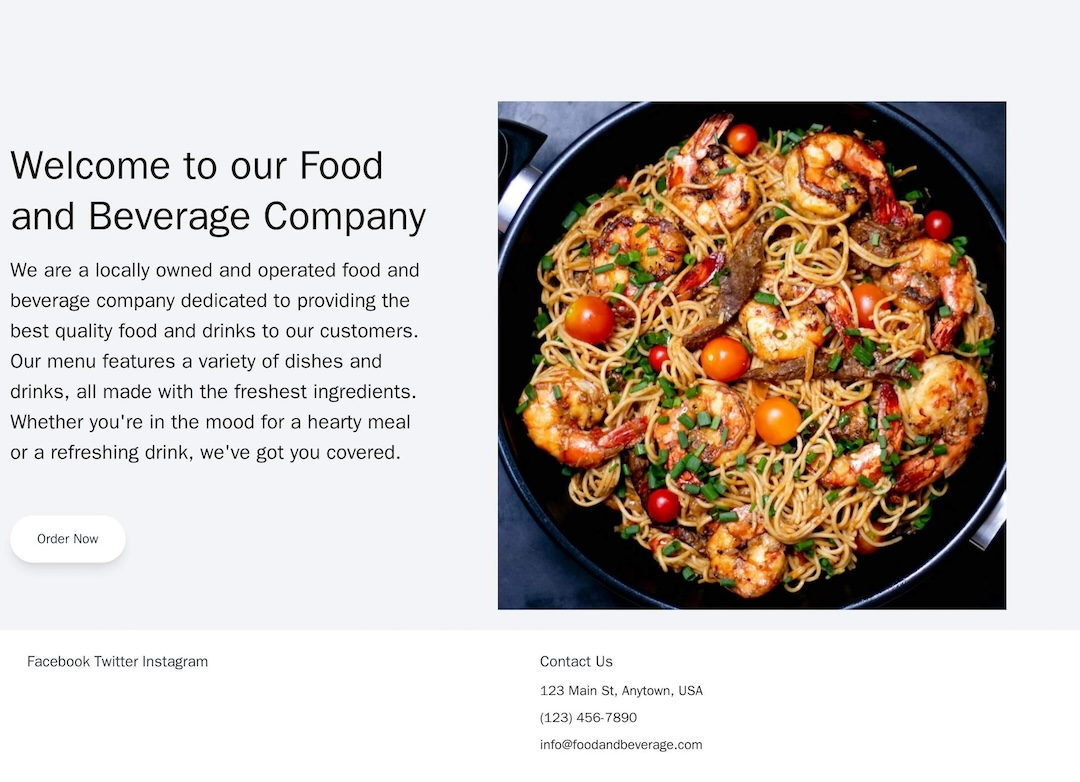



**This code tutorial walks the user through the different steps of that pipeline and shares a few tip and tricks.** For more details, check out our [paper](https://huggingface.co/papers/2403.09029).


Our synthetic HTML code generation pipeline involves two key steps
for maximizing diversity and quality. First, we employ a smaller language model to generate a
variety of website themes and designs. These creative outputs serve as the foundation for the next
stage, where they are fed into the prompts of a larger language model mostly trained on code data.
This LLM then generates the final HTML code, ensuring that our dataset encompasses a wide range
of styles while generating high-quality codes.

Let us first load the required libraries that are 🤗 transformers and autoawq library.


In [ ]:
!pip install torch
!pip install transformers

To avoid any mismatches between the backend (and in particular the cuda versions) and autoawq pre-compiled wheels, we will build autoawq and its dependencies from source. It can take a long time (50 mins) but installation will be more reliable.

In [ ]:
!TORCH_CUDA_ARCH_LIST="7.5+PTX" pip install git+https://github.com/casper-hansen/AutoAWQ_kernels.git@main

  Cloning https://github.com/casper-hansen/AutoAWQ_kernels.git (to revision main) to /tmp/pip-req-build-j3246cv_
  Running command git clone --filter=blob:none --quiet https://github.com/casper-hansen/AutoAWQ_kernels.git /tmp/pip-req-build-j3246cv_
  Resolved https://github.com/casper-hansen/AutoAWQ_kernels.git to commit 83d1f4b326a9067d0f94f089ef1bb47cf5377134
  Preparing metadata (setup.py) ... done
  Created wheel for autoawq-kernels: filename=autoawq_kernels-0.0.6+cu122-cp310-cp310-linux_x86_64.whl size=28389610 sha256=91feeb20bbc43573eb9aac6af16c19d9eb9194ca7f893f234ced3d1255725c02
  Stored in directory: /tmp/pip-ephem-wheel-cache-gmbays5p/wheels/ba/5a/6c/3be3e0d2ee41ec70eaa0c04f34dd060827358243eccf238888
Successfully built autoawq-kernels


In [ ]:
!pip install git+https://github.com/casper-hansen/AutoAWQ.git@main

  Cloning https://github.com/casper-hansen/AutoAWQ.git (to revision main) to /tmp/pip-req-build-pr4cvbps
  Running command git clone --filter=blob:none --quiet https://github.com/casper-hansen/AutoAWQ.git /tmp/pip-req-build-pr4cvbps
  Resolved https://github.com/casper-hansen/AutoAWQ.git to commit 94e73f0b2abb1d5303d72231540e922e0484383d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
  Created wheel for autoawq: filename=autoawq-0.2.3+cu122-py3-none-any.whl size=80801 sha256=1bfcf6e7d8f3d42985c63dcb648e3b938c

# Generating diverse website concepts

We employ [Mistral-7B-Instruct v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) to
generate several million unique website concepts and designs with a custom prompt.

In [ ]:
import torch
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, AwqConfig

In [ ]:
import torch
import awq_ext

In [ ]:
device = "cuda"

# To fit the memory of a standard T4 GPU of a google colab, we'll use the quantized version of mistal 7b instruct
# For faster inference, we can also use module fusing
# quantization_config = AwqConfig(
#     bits=4,
#     fuse_max_seq_len=4096,
#     do_fuse=True,
# )
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.2-AWQ",
#     quantization_config=quantization_config,
).to(device)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.2-AWQ")
tokenizer.padding_side = "left"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/4.15G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

The custom prompt provides a few examples of ideas, while instructing the model of the desired output format.

In [ ]:
PROMPT = (
    "Generate diverse website layout ideas for different companies, each with a unique design element. Examples"
    " include: a car company site with a left column, a webpage footer with a centered logo. Explore variations in"
    " colors, positions, and company fields. Don't give any explanations or recognition that you have understood the"
    " request, just give the list of 10 ideas, with a line break between each."
)

We'll generate 20 examples and parse them line by line. It might take a few minutes.

In [ ]:
BATCH_SIZE = 1
NUM_ITER = 2

ALL_IDEAS = []

messages = [{"role": "user", "content": PROMPT},]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
encodeds = encodeds.repeat(BATCH_SIZE, 1)
len_prompt = encodeds.shape[1]
model_inputs = encodeds.to(device)


for _ in tqdm(range(NUM_ITER)):
    generated_ids = model.generate(model_inputs, max_new_tokens=1024, do_sample=True)
    generated_ids = generated_ids[:, len_prompt:]
    decoded = tokenizer.batch_decode(generated_ids)

    for dec_ in decoded:
        try:
            dec = dec_
            dec = dec.replace("</s>", "").replace("\n\n", "\n")
            dec = dec.split("\n")
            dec = [el for el in dec if el[0].isdigit()]
            if len(dec) != 10:
                continue
            dec = [
                el[2:].strip() if el[:2] == f"{idx + 1}." else el[3:].strip() if el[:3] == f"{idx + 1}." else ""
                for idx, el in enumerate(dec)
            ]
            dec = [el for el in dec if el]
            if len(dec) != 10:
                continue
            ALL_IDEAS.extend(dec)
        except Exception:
            print("Skipped")
            pass

  0%|          | 0/2 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 50%|█████     | 1/2 [00:43<00:43, 43.40s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 2/2 [01:18<00:00, 39.11s/it]


Here are the first 10 ideas. Given that we sample from the model, each new call to `generate` will yield different outputs.

In [ ]:
ALL_IDEAS[:10]

['E-commerce Fashion Store: A grid layout featuring high-resolution images of clothing items, with a left sidebar for filters, sizes, and customer reviews. The logo is placed at the top-left, and the navigation menu is horizontal at the top.',
 'Architecture Firm: A minimalist design with large images of architectural projects, sliding left to right. A narrow right column displays text and information about each project, along with a call-to-action button for further details. The logo is centrally placed at the top, and the navigation menu is hidden, revealing on hover.',
 'Tech Company: A three-column layout with a bold, bright color palette. The largest column displays the latest news and product updates, the middle column showcases case studies and success stories, while the right column provides a sign-up form for email updates and a live chat feature. The logo is centered at the top, and the navigation menu is hidden in a hamburger icon.',
 'Travel Agency: A full-screen background

# Generating website codes for these concepts

Equipped with these websites ideas, we leverage a code language model to generate websites (and more specifically their HTML code) from these ideas. We use [Deepseek-Coder](https://huggingface.co/deepseek-ai/deepseek-coder-7b-instruct-v1.5), a state-of-the-art code language model fine-tuned to follow instructions.

For the v0.1 of WebSight, we opted to create HTML pages with traditional CSS for styling. However, a model trained on such data would typically need to generate first a long list of CSS styling elements, and then followed by the HTML structure itself. Such a flow becomes extremely complex as websites become more complex. In this context, [Tailwind CSS](https://github.com/tailwindlabs/tailwindcss) emerges as an ideal
solution. This utility-first framework enables direct styling within the HTML document, eliminating
the need for external style files. Tailwind CSS offers an extensive array of predefined classes that mirror
various CSS properties. By integrating these utility classes into HTML elements, we can efficiently
style web pages, resulting in concise code that is easier for VLMs to interpret and learn.

For WebSight v0.2, we instruct the model to generate styling elements with Tailwind CSS with the following prompt:

In [ ]:
PROMPT = """Code a complete website with a good design in HTML and Tailwind CSS about this: {idea}
Write the code inside a tag <body>.
Write real and long sentences about the business. NEVER USE sentences starting with Lorem ipsum, NEVER.
You don't have to include images, but if you do, use only this source "https://source.unsplash.com/random/WxH/?keyword", by replacing `W` and `H` in the URL by the desired width and height, and `?keyword` by a keyword describing the picture, for example "https://source.unsplash.com/random/300x200/?gym" for an image about gym of size 300x200, or "https://source.unsplash.com/random/100x200/?cake" for an image of a cake of size 100x200."""


In [ ]:
CHAT_TEMPLATE = (
    "{% if not add_generation_prompt is defined %}\n{% set add_generation_prompt = false %}\n{% endif %}\n{%- set ns ="
    " namespace(found=false) -%}\n{%- for message in messages -%}\n    {%- if message['role'] == 'system' -%}\n       "
    " {%- set ns.found = true -%}\n    {%- endif -%}\n{%- endfor -%}\n{{bos_token}}{%- if not ns.found -%}\n{{'You are"
    " a powerful AI programming assistant, able to generate HTML and Tailwind CSS codes to create"
    " beautiful websites.\\n'}}\n{%- endif %}\n{%- for message in messages %}\n    {%- if message['role'] == 'system'"
    " %}\n{{ message['content'] }}\n    {%- else %}\n        {%- if message['role'] == 'user' %}\n{{'###"
    " Instruction:\\n' + message['content'] + '\\n'}}\n        {%- else %}\n{{'### Response:\\n' + message['content']"
    " + '\\n<|EOT|>\\n'}}\n        {%- endif %}\n    {%- endif %}\n{%- endfor %}\n{% if add_generation_prompt"
    " %}\n{{'### Response:'}}\n{% endif %}"
)

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/deepseek-coder-6.7B-instruct-AWQ",
    device_map="cuda"
)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/deepseek-coder-6.7B-instruct-AWQ")
tokenizer.chat_template = CHAT_TEMPLATE

config.json:   0%|          | 0.00/910 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
BATCH_SIZE = 1

MAX_NEW_TOKENS = 2048
PAD_TOKEN_ID = 32014
EOS_TOKEN_ID = 32021

def batch_model_generations(batch_ideas):
    all_messages = [
        [
            {"role": "user", "content": PROMPT.format(idea=idea)},
        ]
        for idea in batch_ideas
    ]
    all_encodeds = [
        tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
        for messages in all_messages
    ]
    len_prompts = [encodeds.shape[1] for encodeds in all_encodeds]
    max_len_prompt = max(len_prompts)
    padded_all_encodeds = torch.full((len(batch_ideas), max_len_prompt), PAD_TOKEN_ID)
    for idx_enc, encodeds in enumerate(all_encodeds):
        padded_all_encodeds[idx_enc, max_len_prompt - len_prompts[idx_enc] :] = encodeds[0]
    model_inputs = padded_all_encodeds.to(device)

    generated_ids = model.generate(
        model_inputs,
        max_new_tokens=MAX_NEW_TOKENS,
        do_sample=False,
        pad_token_id=PAD_TOKEN_ID,
        eos_token_id=EOS_TOKEN_ID,
    )
    generated_ids = generated_ids[:, max_len_prompt:]
    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    decoded = [el.replace(tokenizer.eos_token, "") for el in decoded]
    return decoded


We then define `extract_html_code_from_generation` which checks whether the generated code looks correct (an opening and closing `<body>` tag), and extract the HTML body.

In [ ]:
TEMPLATE_HTML_CODE = """<html>
<link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
{body_html_code}
</html>"""

def extract_html_code_from_generation(generation):
    if (generation.count("<body ") != 1) or (generation.count("</body>") != 1):
        return None
    else:
        pos_start_html_code = generation.find("<body ")
        pos_end_html_code = pos_start_html_code + generation[pos_start_html_code:].find("</body>") + len("</body>")
        body_html_code = generation[pos_start_html_code:pos_end_html_code]
        html_code = TEMPLATE_HTML_CODE.format(body_html_code=body_html_code)
        return html_code


We notice that some colors were over-represented. `replace_overused_color_from_html_code` introduces some randomnes in the colors.

In [ ]:
import random

OVERUSED_COLOR = "blue"
LIST_COLORS = ["gray", "red", "yellow", "green", "blue", "indigo", "purple", "pink"]

def replace_overused_color_from_html_code(html_code):
    random_color = random.choice(LIST_COLORS)
    html_code = html_code.replace(OVERUSED_COLOR, random_color)
    return html_code


We generate the HTML codes from the ideas generated in the first step by putting everything together.

In [ ]:
IDEAS_AND_HTML_CODES = []

for idx in tqdm(range(0, len(ALL_IDEAS), BATCH_SIZE)):
    batch_ideas = ALL_IDEAS[idx : idx + BATCH_SIZE]
    batch_generated_html_codes = batch_model_generations(batch_ideas=batch_ideas)
    for idea, generation in zip(batch_ideas, batch_generated_html_codes):
        html_code = extract_html_code_from_generation(generation=generation)
        if html_code is not None:
            html_code = replace_overused_color_from_html_code(html_code=html_code)
            IDEAS_AND_HTML_CODES.append([idea, html_code])


100%|██████████| 20/20 [18:52<00:00, 56.64s/it]


We can look at the first generation, we have the idea and the generated HTML.

In [ ]:
IDEAS_AND_HTML_CODES[0]

['E-commerce Fashion Store: A grid layout featuring high-resolution images of clothing items, with a left sidebar for filters, sizes, and customer reviews. The logo is placed at the top-left, and the navigation menu is horizontal at the top.',
 '<html>\n<link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">\n<body class="font-sans antialiased text-gray-900 leading-normal tracking-wider bg-gray-100">\n    <header class="bg-white shadow-md">\n        <div class="container mx-auto px-4">\n            <div class="flex items-center justify-between py-6">\n                <a href="#" class="text-xl font-bold">E-commerce Fashion Store</a>\n                <nav>\n                    <ul class="flex space-x-4">\n                        <li><a href="#" class="hover:text-pink-500">Home</a></li>\n                        <li><a href="#" class="hover:text-pink-500">Products</a></li>\n                        <li><a href="#" class="hover:text-pink-500">Abo

# Filtering poor quality generations

Now that we have HTML generations, we are going to filter them based on a series of simple heuristics:
- a page should not contain less than 10 words
- a page should not contain paths to image file
- a page should not contain "template" sentences such as "lorem ipsum"

In [ ]:
# Trick to install selectolax, taken from https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


# selectolax is a super fast HTML parser
!pip install selectolax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 23.5 MB/s eta 0:00:00


In [ ]:
from selectolax.parser import HTMLParser
from string import punctuation, whitespace
from typing import List, Union

class HTMLWordCounter:
    def __call__(self, html_str: str) -> int:
        html_str = self._remove_html_comments(html_str=html_str)

        selectolax_tree = self._make_selectolax_tree(html_str=html_str)
        text = selectolax_tree.root.text(deep=True, separator=" ", strip=False)
        text = self._replace_breaking_lines_by_whitespaces(text=text)

        words = self._get_words_from_text(text=text)
        words = self._remove_punctuations_and_whitespaces(words)
        words = self._remove_empty_elements_from_list(words)
        num_words = len(words)
        return num_words

    def _remove_html_comments(self, html_str: str) -> str:
        html_str = re.sub(r"<!--(?s).*?-->", "", html_str)
        return html_str

    def _make_selectolax_tree(self, html_str: str) -> HTMLParser:
        selectolax_tree = HTMLParser(html_str)
        return selectolax_tree

    def _replace_breaking_lines_by_whitespaces(self, text: str) -> str:
        text = text.replace("\n", " ")
        return text

    def _get_words_from_text(self, text: str) -> List[str]:
        words = text.split(" ")
        return words

    def _remove_punctuations_and_whitespaces(self, list_: List[str]) -> List[str]:
        list_ = [el.strip(punctuation + whitespace) for el in list_]
        return list_

    def _remove_empty_elements_from_list(self, list_: Union[List[str], None]) -> List[str]:
        list_ = [el for el in list_ if el]
        return list_

In [ ]:
class HTMLFiltering:
    def __init__(self, list_ban_substrings: List[str], threshold_min_num_words: int) -> None:
        self.list_ban_substrings = list_ban_substrings
        self.threshold_min_num_words = threshold_min_num_words
        self.html_word_counter = HTMLWordCounter()

    def __call__(self, html_str: str) -> bool:
        html_str = html_str.lower()
        if any([(ban_substring in html_str) for ban_substring in self.list_ban_substrings]):
            return False
        if self.html_word_counter(html_str=html_str) < 10:
            return False
        return True

In [ ]:
import re

LIST_BAN_SUBSTRINGS = ["lorem", "?gym", "?cake", "description", ".png", ".jpg", ".jpeg"]
THRESHOLD_MIN_NUM_WORDS = 10

html_filtering = HTMLFiltering(
    list_ban_substrings=LIST_BAN_SUBSTRINGS, threshold_min_num_words=THRESHOLD_MIN_NUM_WORDS
)
IDEAS_AND_HTML_CODES = [
    (idea, html_code) for idea, html_code in tqdm(IDEAS_AND_HTML_CODES) if html_filtering(html_str=html_code)
]

  0%|          | 0/17 [00:00<?, ?it/s]<ipython-input-18-92f1cf1c29c8>:20: DeprecationWarning: Flags not at the start of the expression '<!--(?s).*?-->' but at position 4
  html_str = re.sub(r"<!--(?s).*?-->", "", html_str)
100%|██████████| 17/17 [00:00<00:00, 4417.52it/s]


# Rendering webpages with Playwright

Now that we have the HTML codes, we use [Playwright](https://github.com/microsoft/playwright) to render the screenshots from the codes.

We first install Playwright and download the necessary web runners. For the scope of this tutorial, we do not need to worry about the `Host system is missing dependencies to run browsers.` warning.



In [ ]:
!pip install playwright
!playwright install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 12.5 MB/s eta 0:00:00
154.7 MiB [] 0% 0.0s154.7 MiB [] 0% 80.0s154.7 MiB [] 0% 30.4s154.7 MiB [] 0% 14.9s154.7 MiB [] 0% 11.7s154.7 MiB [] 0% 10.5s154.7 MiB [] 1% 8.5s154.7 MiB [] 1% 8.6s154.7 MiB [] 1% 8.5s154.7 MiB [] 2% 8.6s154.7 MiB [] 2% 8.7s154.7 MiB [] 2% 9.3s154.7 MiB [] 2% 9.2s154.7 MiB [] 2% 9.3s154.7 MiB [] 2% 8.7s154.7 MiB [] 3% 7.9s154.7 MiB [] 3% 7.7s154.7 MiB [] 4% 7.5s154.7 MiB [] 4% 7.4s154.7 MiB [] 4% 7.2s154.7 MiB [] 5% 6.9s154.7 MiB [] 5% 6.7s154.7 MiB [] 6% 6.3s154.7 MiB [] 6% 6.1s154.7 MiB [] 7% 5.8s154.7 MiB [] 7% 5.9s154.7 MiB [] 7% 5.8s154.7 MiB [] 8% 5.7s154.7 MiB [] 8% 5.6s154.7 MiB [] 8% 5.5s154.7 MiB [] 9% 5.4s154.7 MiB [] 10% 5.2s154.7 MiB [] 10% 5.0s154.7 MiB [] 11% 4.9s154.7 MiB [] 12% 5.0s154.7 MiB [] 12% 4.8s154.7 MiB [] 13% 4.9s154.7 MiB [] 13% 4.8s154.7 MiB [] 14% 4.7s154.7 MiB [] 15% 4.5s154.7 MiB [] 15% 4.4s154.7 MiB [] 16% 4.2s154.7 MiB [] 17% 4.2s154.7 MiB [] 17% 4.1s154.7 MiB [] 18% 4.0s

In [ ]:
# from playwright.sync_api import sync_playwright
from playwright.async_api import async_playwright
from PIL import Image
from io import BytesIO
import asyncio

In [ ]:
USER_AGENT_PLAYWRIGHT = (
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
)
JPG_QUALITY = 65


def modify_image_urls(html_code: str) -> str:
    """When an image URL appears more than once, when the HTML is rendered,
    the same image is displayed. The trick is to add a `_` at the end of the
    keyword of the URL to generate another image, still corresponding to the
    same keyword.
    """
    pattern = re.compile(r"https://source\.unsplash\.com/random/\d+x\d+/\?(\w+)")
    url_counts = {}

    def replace_url(match):
        keyword = match.group(1)
        url_counts[keyword] = url_counts.get(keyword, 0) + 1
        modified_keyword = keyword + "_" * (url_counts[keyword] - 1)
        return match.group(0).replace(keyword, modified_keyword)

    modified_html_code = pattern.sub(replace_url, html_code)
    return modified_html_code

def convert_png_to_jpg(bytes_image_png: bytes, jpg_quality: int) -> Image.Image:
    image_png = Image.open(BytesIO(bytes_image_png))
    image_png = image_png.convert("RGB")
    output = BytesIO()
    image_png.save(output, format="JPEG", quality=jpg_quality)
    bytes_image_jpg = output.getvalue()
    image_jpg = Image.open(BytesIO(bytes_image_jpg))
    return image_jpg


Note that playwright cannot run the `sync_playwright` API in google colab. It is recommended to use the async API instead, `async_playwright`.

If you are running in a regular local python code, you can replace `from playwright.async_api import async_playwright` by `from playwright.sync_api import sync_playwright` and strip the `async` and `await` keywords in the following code.


In [ ]:
IDEAS_SCREENSHOTS_AND_HTML_CODES = []

async with async_playwright() as p:
    browser = await p.chromium.launch(headless=True)
    context = await browser.new_context(user_agent=USER_AGENT_PLAYWRIGHT, device_scale_factor=2)
    for idea, html_code in IDEAS_AND_HTML_CODES:
        page = await context.new_page()
        html_code_modif_image_urls = modify_image_urls(html_code=html_code)
        await page.set_content(html_code_modif_image_urls)
        await page.wait_for_load_state("networkidle")
        screenshot_data = await page.screenshot(full_page=True)
        image_jpg = convert_png_to_jpg(bytes_image_png=screenshot_data, jpg_quality=JPG_QUALITY)
        IDEAS_SCREENSHOTS_AND_HTML_CODES.append((idea, image_jpg, html_code))
    await context.close()
    await browser.close()

We now have a rendered web page for each generated HTML code, let's look at the first two!

You'll notice that the web pages contain real images. Yet, we did not create image any local image. Images are enabled using a random image generator: `https://source.unsplash.com/random/WxH/?keyword` will return a random image of desired height and width (`W` and `H`) and `keyword` gives control over the topic of the image. See the prompt for more details.

In [ ]:
import matplotlib.pyplot as plt

Idea: E-commerce Fashion Store: A grid layout featuring high-resolution images of clothing items, with a left sidebar for filters, sizes, and customer reviews. The logo is placed at the top-left, and the navigation menu is horizontal at the top.




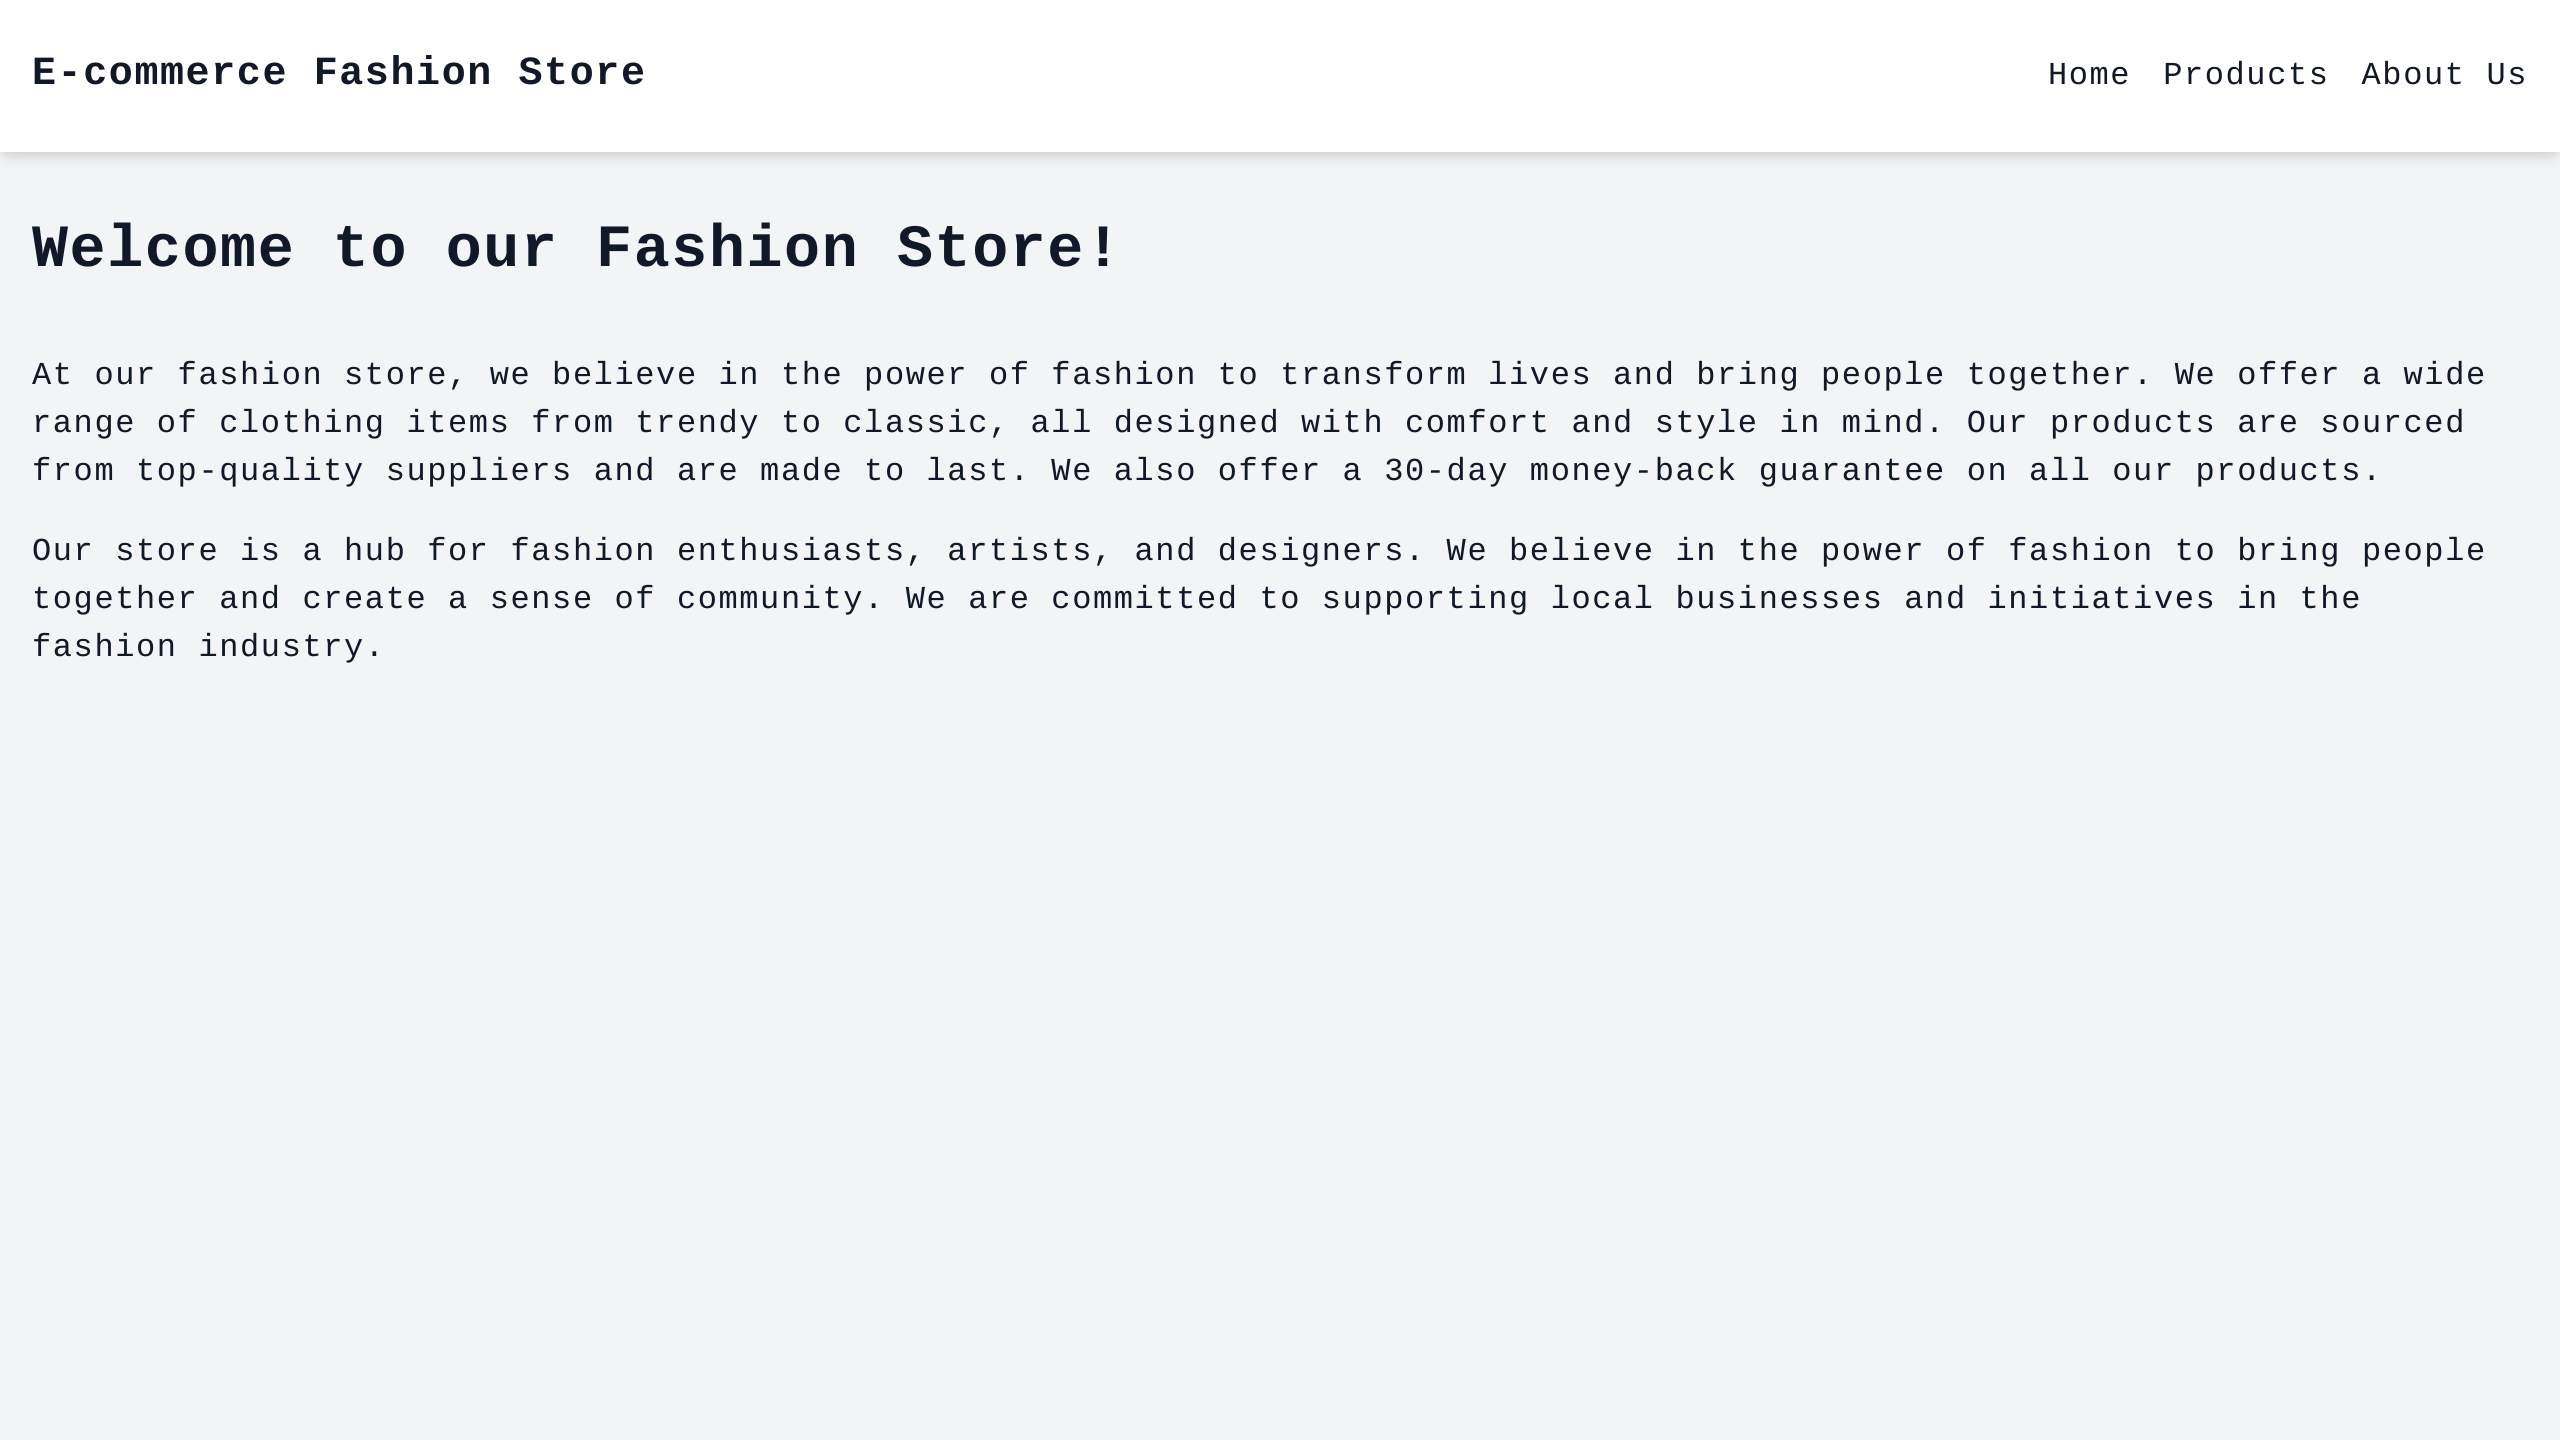

In [ ]:
idea, image, _ = IDEAS_SCREENSHOTS_AND_HTML_CODES[0]
print(f"Idea: {idea}\n\n")
image

Idea: Tech Company: A three-column layout with a bold, bright color palette. The largest column displays the latest news and product updates, the middle column showcases case studies and success stories, while the right column provides a sign-up form for email updates and a live chat feature. The logo is centered at the top, and the navigation menu is hidden in a hamburger icon.




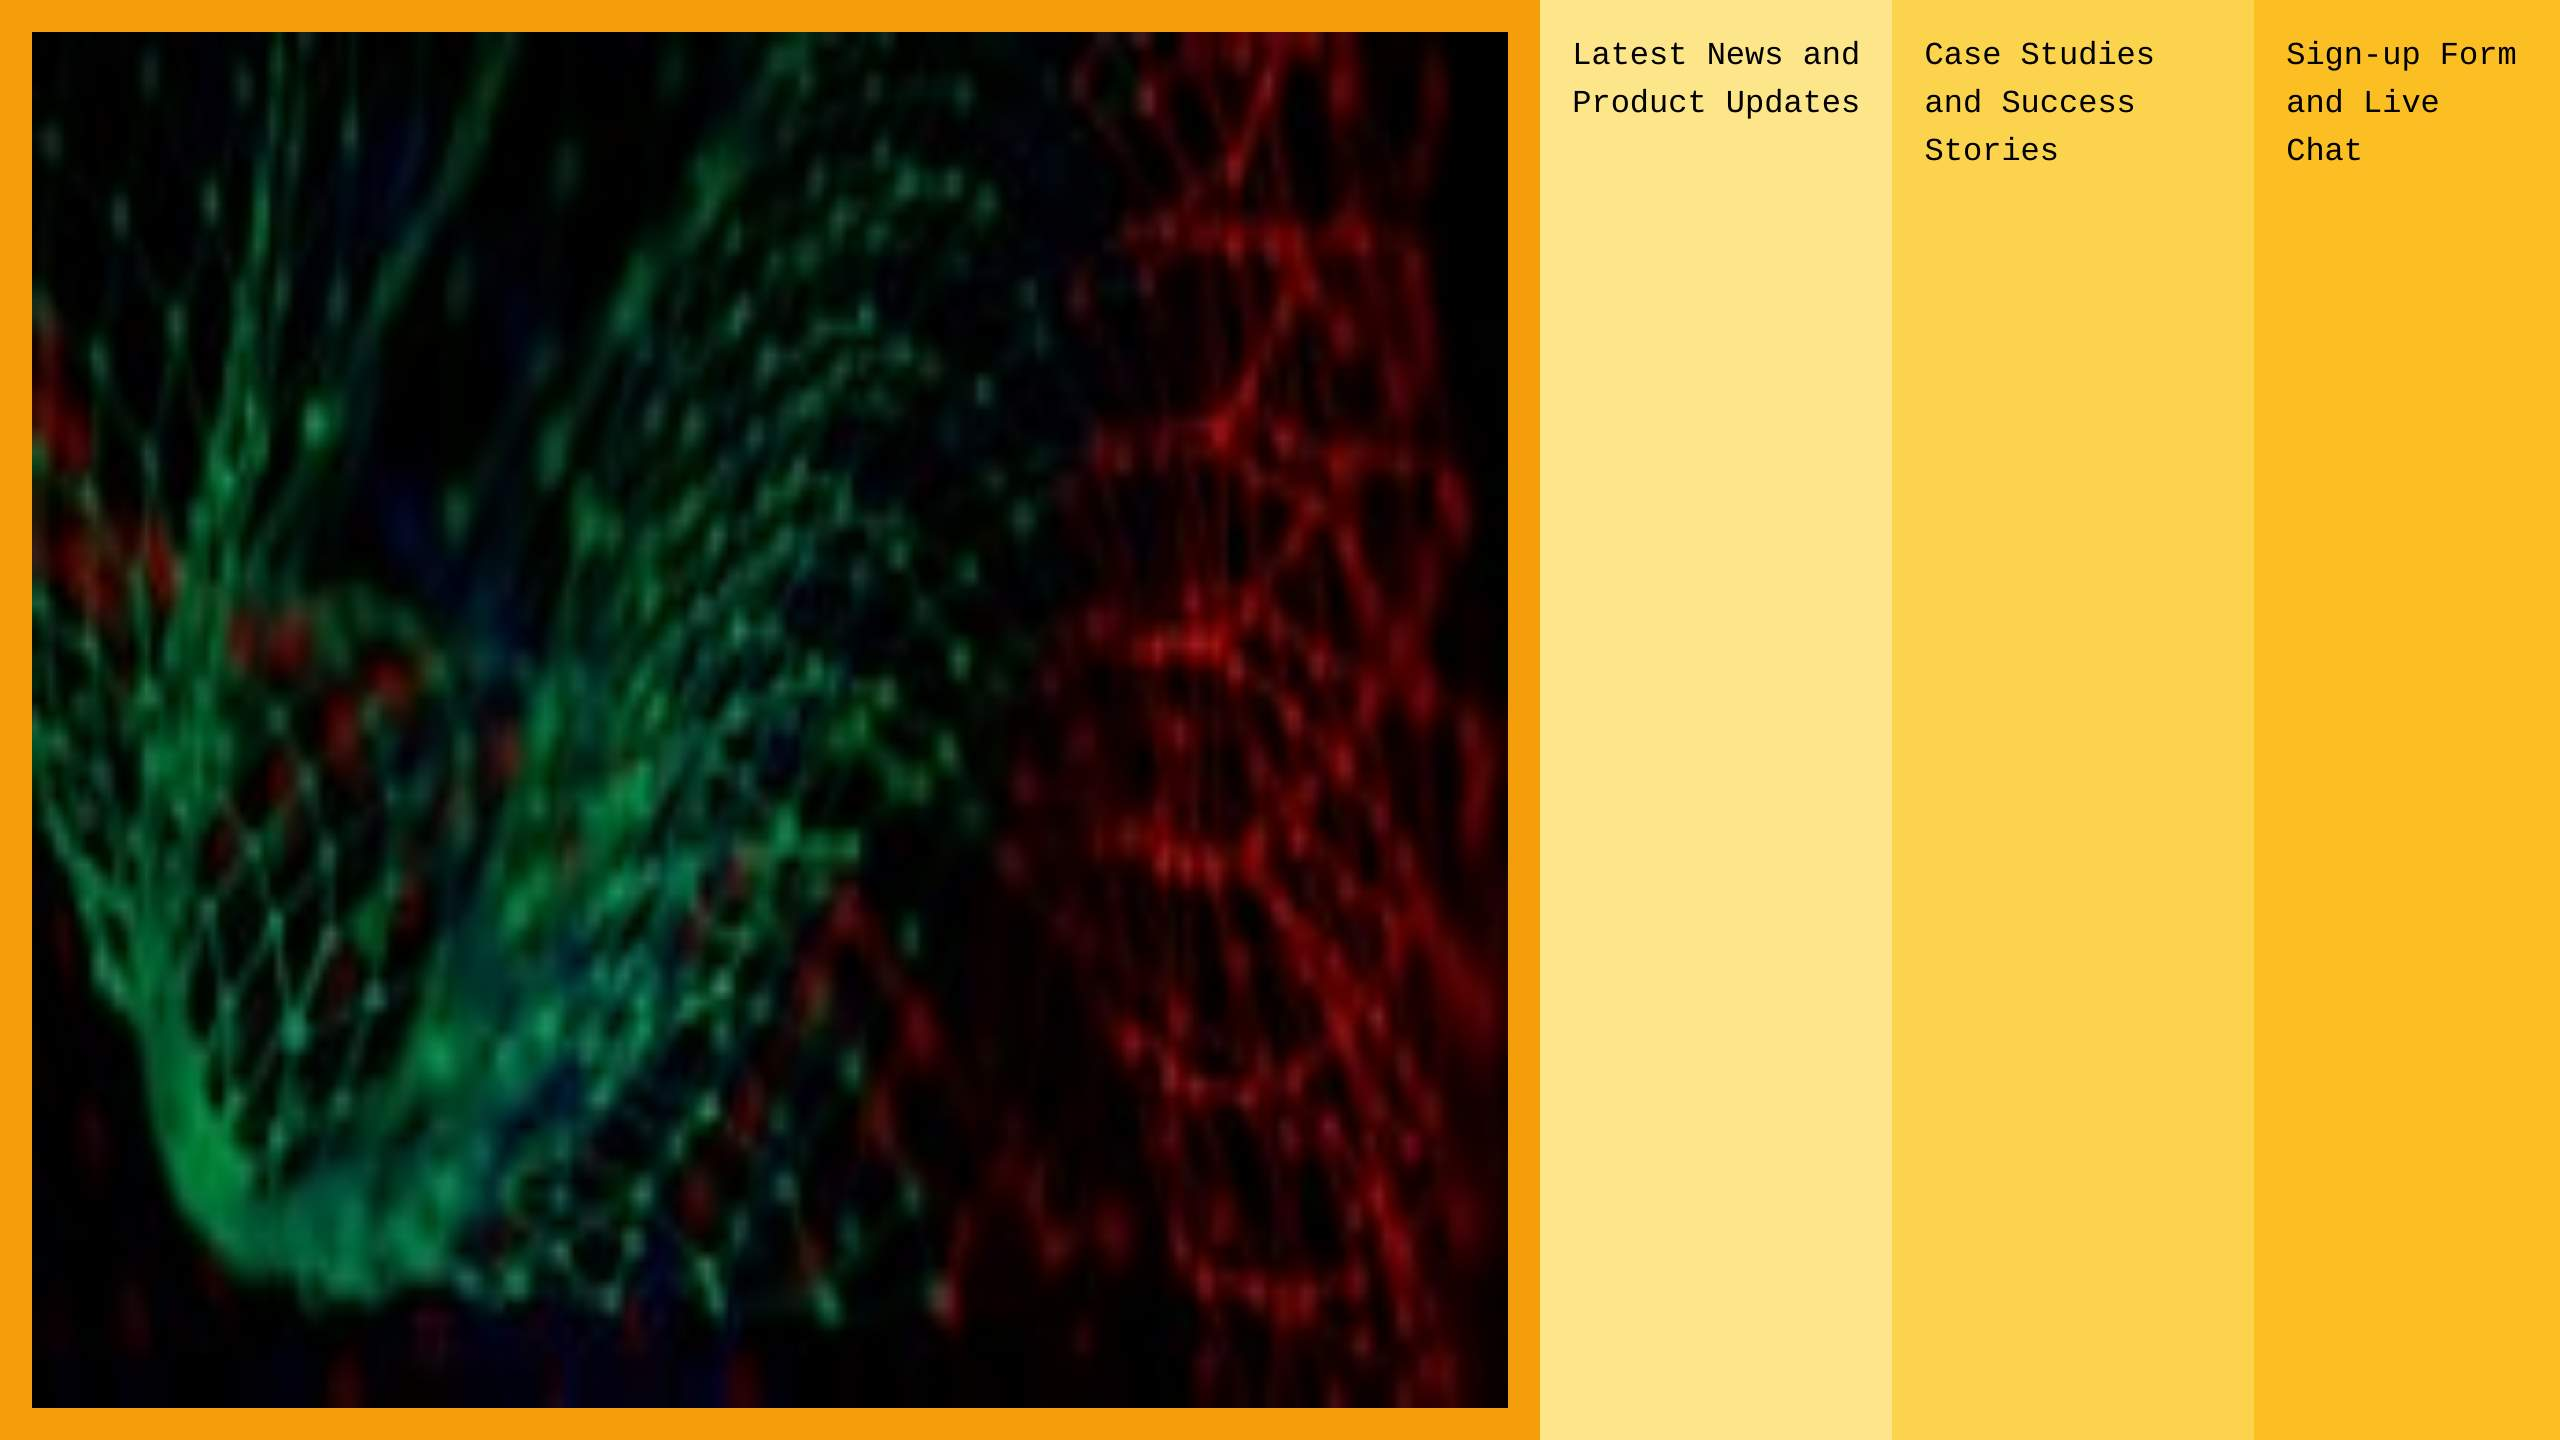

In [ ]:
idea, image, _ = IDEAS_SCREENSHOTS_AND_HTML_CODES[1]
print(f"Idea: {idea}\n\n")
image

# Conclusion

We have demonstrated how to put together a simple pipeline to synthetically create pairs of web screenshots and their associated HTML codes using pre-trained language models.

While we used relatively small language models in this tutorial, we scaled the pipeline using bigger and more powerful versions of the language models (and more scalable plumbing between the different components), to obtaind 2 million pairs of screenshots and HTML codes. The full dataset is available [here](https://huggingface.co/datasets/HuggingFaceM4/WebSight).

